# Phasefield Localization in 1D

In this tutorial, we will demonstrate how to simulate phasefield localization in a one-dimensional bar using spectral methods. We will utilize the `xpektra` library for spectral computations and `jax` for automatic differentiation. The goal is to minimize the energy functional associated with the phasefield variable, which represents the damage state of the material.

This tutorial shows how to use the `xpektra` library for how to solve a minimization problem using spectral methods in 1D and pair it with `jax` for automatic differentiation to compute gradients and Hessians.

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
from xpektra import SpectralSpace
from xpektra.transform import FFTTransform
from xpektra.spectral_operator import SpectralOperator
from xpektra.scheme import FourierScheme

We start with defining the 1D localization problem using phase field modeling. We consider a bar of length `length` discretized into `N` points. The phase field variable `alpha` represents the damage state of the material, where `alpha = 0` indicates undamaged material and `alpha = 1` indicates fully damaged material.

The objective function to be minimized is as follows:

$$ \textsf{min} \int_\Omega  \Big( \alpha + \ell_0^2 \nabla   \alpha \cdot{} \nabla \alpha \Big) \textsf{d}\Omega $$

$$ \textsf{such that} ~ 0 <  \alpha(x) < 1 $$



In [ ]:
N = 69
ndim = 1
length = 10
dx = length / N

ell = 1.0

From `xpektra`, we import necessary modules to set up the spectral space, transformations, and operators needed for our computations. To handle the gradients and Laplacians in the spectral domain, we utilize Fourier transforms.

In [4]:
fft_transform = FFTTransform(ndim)
space = SpectralSpace(shape=(N,), lengths=(length,), transform=fft_transform)
scheme = FourierScheme(space=space)
op = SpectralOperator(scheme=scheme, space=space)

Now we can define our objective function and compute its Jacobian and Hessian using JAX's automatic differentiation capabilities.

In [ ]:
@jax.jit
def f(alpha):
    grad_alpha = op.grad(alpha)
    energy = alpha + ell * ell * grad_alpha * grad_alpha
    return energy.sum() * dx ** ndim

jacobian = jax.jacrev(f)
hessian= jax.jacfwd(jacobian)

We start by imposing a seed crack at the center of the bar to initiate the localization process.


In [25]:
alpha0 = 1.
alpha = jnp.zeros(N)
alpha = alpha.at[int(N/2)].set(alpha0)

We perform the constrained  minimization using the `scipy.optimize.minimize` function with the 'SLSQP' method, which is suitable for handling bound constraints on the phase field variable `alpha`. The optimization iteratively updates `alpha` to minimize the objective function while ensuring that it remains within the specified bounds.


In [32]:
from scipy.optimize import minimize, Bounds

In [33]:
lower_bounds = jnp.zeros_like(alpha)
upper_bounds = jnp.ones_like(alpha)

bnds = Bounds(lb=lower_bounds, ub=upper_bounds)
cons = ({'type': 'eq', 'fun': lambda x:  x[int(N/2)] - alpha0})
res = minimize(f, alpha, method='SLSQP', jac=jacobian,  bounds=bnds, constraints=cons)


Finally, we visualize the resulting phase field distribution along the bar, which illustrates the localization of damage initiated from the seed crack. The plot shows how `alpha` varies from 0 (undamaged) to 1 (fully damaged) along the length of the bar.

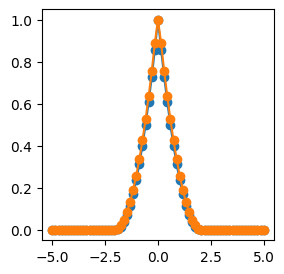

In [34]:
def ppos(x):
    return np.maximum(x, np.zeros_like(x))

x = np.linspace(-length/2, length/2, num=N)
alpha_an = (ppos(np.sqrt(alpha0) - np.abs(x / 2 / ell))) ** 2

plt.figure(figsize=(3, 3))
plt.plot(x, alpha_an, 'o-')
plt.plot(x, res.x, 'o-')
plt.show()